# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 07.10.2023

Мягкий дедлайн: 23:59MSK 20.10.2023

Жесткий дедлайн: 23:59MSK 24.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.6 + max(task_1, task_2)*0.2 + task_4*0.2
$$

где $task_1$, $task_2$ и $task_4$ - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [5]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-10-24 19:03:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [           <=>      ] 201.24M  96.9MB/s    in 2.1s    

2024-10-24 19:03:44 (96.9 MB/s) - ‘data.txt.zip’ saved [211011981]



In [6]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [7]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [8]:
device

'cuda'

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

def rmse(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean().sqrt()

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse

model = Ridge(alpha=1)
model.fit(X_train, y_train)
y_pred_t = model.predict(X_train)
y_pred = model.predict(X_test)

print(mse(y_test, scaler_y.inverse_transform(y_pred)) ** 0.5)

9.510160820470436


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [10]:
y_mean= np.mean(scaler_y.inverse_transform(y_train))
rmse_for_mean = mse(y_test, np.ones_like(y_test)*y_mean) ** 0.5
print(rmse_for_mean)

10.85246390513634


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [11]:
#берем обучающую выборку 10%

y_train = torch.tensor(y_train[:len(y_train) // 10], dtype=torch.float32)
y_test = torch.tensor(y_test[:len(y_test) // 10], dtype=torch.float32)
X_train = torch.tensor(X_train[:len(X_train) // 10], dtype=torch.float32)
X_test = torch.tensor(X_test[:len(X_test) // 10], dtype=torch.float32)

class Zheka(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Zheka, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

model = Zheka(90, 1)

set_random_seed(42)
learning_rate = 0.1
epochs = 10
batch_size = 32

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    y_pred = model(X_train)
    loss = rmse(y_pred, y_train)
    loss.backward()
    with torch.no_grad():
        for param in model.parameters(): # градиентный шаг
            param -= learning_rate * param.grad
    model.zero_grad()

    # Валидация
    with torch.no_grad():

        y_pred_train = model(X_train)
        y_pred_train = torch.tensor(scaler_y.inverse_transform(y_pred_train), dtype=torch.float32)
        y_train_d = torch.tensor(scaler_y.inverse_transform(y_train), dtype=torch.float32)
        loss_train = rmse(y_pred_train, y_train_d)
        train_losses.append(loss_train.item())

        y_pred_test = model(X_test)
        y_pred_test = torch.tensor(scaler_y.inverse_transform(y_pred_test), dtype=torch.float32)
        test_loss = rmse(y_pred_test, torch.tensor(y_test, dtype=torch.float32))
        test_losses.append(test_loss.item())

# Вывод
print(train_losses[-1], test_losses[-1])

9.926835060119629 11.202383041381836


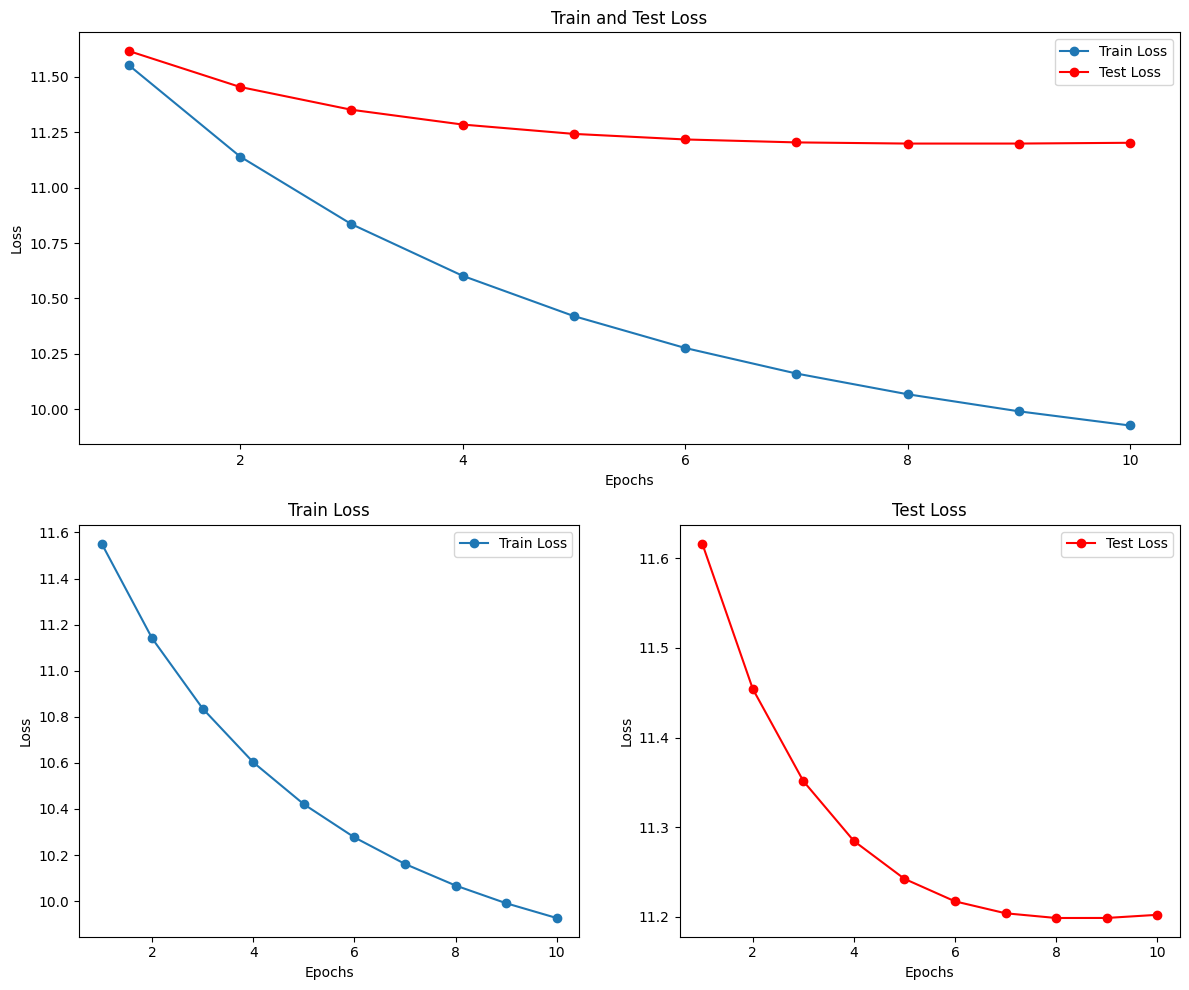

In [12]:
import matplotlib.gridspec as gridspec
epochs = np.arange(1,11)

fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax0 = plt.subplot(gs[0])
ax0.plot(epochs, train_losses, '-o', label='Train Loss')
ax0.plot(epochs, test_losses, '-ro', label='Test Loss')
ax0.set_title('Train and Test Loss')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Loss')
ax0.legend()

gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1])

ax1 = plt.subplot(gs1[0])
ax1.plot(epochs, train_losses, '-o', label='Train Loss')
ax1.set_title('Train Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2 = plt.subplot(gs1[1])
ax2.plot(epochs, test_losses, '-ro', label='Test Loss')
ax2.set_title('Test Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()


## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

  0%|          | 0/807 [00:00<?, ?it/s]

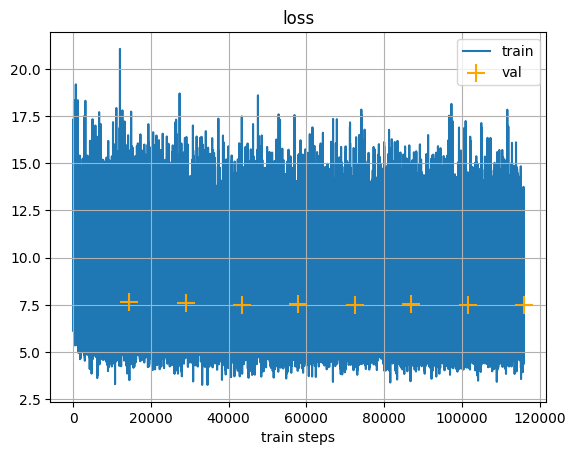

Train loss: tensor(8.3277, dtype=torch.float64)
Val loss: tensor(7.5045, dtype=torch.float64)
Loss: 8.74200841115753


  0%|          | 0/807 [00:00<?, ?it/s]

Loss: 8.74200841115753


In [13]:
set_random_seed(42)

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

scaler = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))

y_train = torch.tensor(y_train[:len(y_train)], dtype=torch.float32)
y_test = torch.tensor(y_test[:len(y_test)], dtype=torch.float32)
X_train = torch.tensor(X_train[:len(X_train)], dtype=torch.float32)
X_test = torch.tensor(X_test[:len(X_test)], dtype=torch.float32)


set_random_seed(42)

def loss(x,y):
    return(torch.sqrt(nn.MSELoss()(x,y)))
criterion = loss
model = nn.Sequential(
    nn.Linear(90, 128),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 1)
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.007, momentum = 0.7)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)

#Даталоадер был на первом семинаре
set_random_seed(100)
class RandomDataset(torch.utils.data.Dataset):

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {"sample": self.x[idx, :].clone().detach().float(), "target": self.y[idx]}


test_set = RandomDataset(X_test, y_test)
train_set = RandomDataset(X_train, y_train)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32,shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32,shuffle = False)


set_random_seed(42)
def train(model, optimizer, criterion, train_loader, test_loader):
    # Функции для вычисления потерь
    def compute_train_loss(y_pred, y_true):
        y_pred_inv = torch.tensor(scaler_y.inverse_transform(y_pred.reshape(-1, 1)))
        y_true_inv = torch.tensor(scaler_y.inverse_transform(y_true.reshape(-1, 1)))
        return criterion(y_pred_inv, y_true_inv)

    def compute_val_loss(y_pred, y_true):
        y_pred_inv = torch.tensor(scaler_y.inverse_transform(y_pred.reshape(-1, 1)))
        return criterion(y_pred_inv, torch.unsqueeze(y_true, 1))

#Обучаемся
    train_loss_log, val_loss_log = [], []
    for epoch in range(8):
        train_epoch_loss = torch.empty(0)
        model.train()

        for batch in tqdm(train_loader):
            x_train_t, y_train_t = batch['sample'].float(), batch['target'].float()
            y_pred_t = model(x_train_t)
            loss = criterion(y_pred_t, y_train_t)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            with torch.no_grad():
                train_loss = compute_train_loss(y_pred_t, y_train_t)
                train_epoch_loss = torch.cat((train_epoch_loss, train_loss.unsqueeze(0)))
                train_loss_log.append(train_loss)

        scheduler.step()

        val_epoch_loss = torch.empty(0)
        model.eval()

        with torch.no_grad():
            for batch in tqdm(test_loader):
                x_test_v, y_test_v = batch['sample'].float(), batch['target'].float()
                y_pred_v = model(x_test_v)
                val_loss = compute_val_loss(y_pred_v, y_test_v)
                val_epoch_loss = torch.cat((val_epoch_loss, val_loss.unsqueeze(0)))

        val_loss_log.append(val_epoch_loss.mean())
        clear_output()
        test_loader_final = torch.utils.data.DataLoader(test_set, batch_size=64)
        predicts = test(model, criterion, test_loader_final)
        y_test_final = torch.unsqueeze(torch.tensor(y_test), 1)
        plot_history(train_loss_log, val_loss_log, "loss")
        print("Train loss:", train_epoch_loss.mean())
        print("Val loss:", val_epoch_loss.mean())
        print(f"Loss: {criterion(predicts, y_test_final)}")

# Тестируем
def test(model, criterion, test_loader_final):
    with torch.no_grad():
        predicts = [torch.tensor(scaler_y.inverse_transform(model(batch['sample'].float()).reshape(-1, 1)))
                    for batch in tqdm(test_loader_final)]
        return torch.cat(predicts, 0)

#график из 3 сема
set_random_seed(42)
from IPython.display import clear_output
import matplotlib.pyplot as plt
def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label="train", zorder=1)

    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]

    plt.scatter(steps, val_history, marker='+', s=180, c="orange", label="val", zorder=2)
    plt.xlabel("train steps")

    plt.legend(loc="best")
    plt.grid()

    plt.show()

set_random_seed(42)
train(model, optimizer, criterion, train_loader, test_loader)
test_loader_final = torch.utils.data.DataLoader(test_set, batch_size=64)
predicts = test(model, criterion, test_loader_final)
y_test_final = torch.unsqueeze(torch.tensor(y_test), 1)
print(f"Loss: {criterion(predicts, y_test_final)}")

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Сначала я пытался подобрать оптимизатор, выбирал между SGD и Adam. После нескольких итераций обучения и тестирования я понял, что Adam лучше, чем SGD, однако потом что-то пошло не так с Adam'ом и я решил использовать SGD. Он и сходился быстрее, и показывал лучшие результаты на тестовых данных.

Далее я подбирал лернинг рейт. Я много раз обучал модель, изменяя этот параметр, и в итоге нашел оптимальное значение.

Так же я увеличил количество слоев в сетке. Это сильно помогло, и модель стала лучше улавливать сложные зависимости в данных. Более того, я протестировал сигмоиду и ReLU и сигмоида оказалась сильно хуже. Наверное, это можно объяснить тем, что сигмоида может вызвать проблемы затухания градиента в глубоких сетях, в то время как ReLU не имеет такого недостатка. Много времени ушло на подбор оптимальной гаммы для шедулера и дропаута.

Вот мои последние 5 экспериментов по подбору коэффициента для дропаута:

Dropout(0.14) - 8.7517

Dropout(0.13) - 8.7506

Dropout(0.11) - 8.7469

Dropout(0.12) - 8.7445 (мне захотелось еще лучшего качества, да)

Dropout(0.1) - 8.7420 (и я сделал еще лучше!)



## Задание 4. (10 баллов)

А теперь давайте попробуем решить задачу классификации на тех же данных!

Протестируйте два варианта:

1. Cчитайте каждый год, представленный в таблице, за отдельный класс

2. Разбейте года на 10 бинов и решайте задачу классификации для 10 классов

Добавьте в test подсчет метрик: accuracy, precision, recall (можете выбрать micro или macro усреднение, как посчитаете нужным).

Что можно сказать о полученных моделях? Почему результаты вышли такими? Напишите небольшой анализ того, что было проделано, чем модели классификации отличаются от задачи регрессии и друг друга?

In [14]:
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder

set_random_seed(42)

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

class YearBinClassifier(nn.Module):
    def __init__(self, n_features, num_classes):
        super(YearBinClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, num_classes)
        )

    def forward(self, X):
        return self.model(X)

def train_model(model, optimizer, criterion, train_loader, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch in tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{epochs}'):
            x_train_t, y_train_t = batch['sample'], batch['target']

            optimizer.zero_grad()
            outputs = model(x_train_t)
            loss = criterion(outputs, y_train_t)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x_train_t.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Testing'):
            x_test_t, y_test_t = batch['sample'], batch['target']
            outputs = model(x_test_t)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(y_test_t.numpy())

    return np.array(all_preds), np.array(all_labels)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {"sample": self.x[idx], "target": self.y[idx]}

train_set = CustomDataset(X_train, y_train)
test_set = CustomDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

num_classes = len(label_encoder.classes_)
n_features = X_train.shape[1]

model = YearBinClassifier(n_features=n_features, num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_model(model, optimizer, criterion, train_loader, epochs=10)

predictions, labels = test_model(model, test_loader)

Training Epoch 1/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch 1, Loss: 3.1677


Training Epoch 2/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch 2, Loss: 3.0959


Training Epoch 3/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch 3, Loss: 3.0795


Training Epoch 4/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch 4, Loss: 3.0695


Training Epoch 5/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch 5, Loss: 3.0641


Training Epoch 6/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch 6, Loss: 3.0588


Training Epoch 7/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch 7, Loss: 3.0564


Training Epoch 8/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch 8, Loss: 3.0539


Training Epoch 9/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch 9, Loss: 3.0511


Training Epoch 10/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch 10, Loss: 3.0489


Testing:   0%|          | 0/807 [00:00<?, ?it/s]

In [16]:
def accuracy(predictions, labels):
    if predictions.dim() == 1:
        preds = predictions
    else:
        _, preds = torch.max(predictions, dim=1)

    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct / total

def precision(predictions, labels, num_classes):
    if predictions.dim() == 1:
        preds = predictions
    else:
        _, preds = torch.max(predictions, dim=1)

    precisions = []

    for class_idx in range(num_classes):
        true_positives = ((preds == class_idx) & (labels == class_idx)).sum().item()
        predicted_positives = (preds == class_idx).sum().item()

        if predicted_positives == 0:
            precision_class = 0.0
        else:
            precision_class = true_positives / predicted_positives

        precisions.append(precision_class)

    return sum(precisions) / num_classes  # макро-усреднение

def recall(predictions, labels, num_classes):
    if predictions.dim() == 1:
        preds = predictions
    else:
        _, preds = torch.max(predictions, dim=1)

    recalls = []

    for class_idx in range(num_classes):
        true_positives = ((preds == class_idx) & (labels == class_idx)).sum().item()
        actual_positives = (labels == class_idx).sum().item()

        if actual_positives == 0:
            recall_class = 0.0
        else:
            recall_class = true_positives / actual_positives

        recalls.append(recall_class)

    return sum(recalls) / num_classes  # макро-усреднение

predictions_tensor = torch.tensor(predictions)
labels_tensor = torch.tensor(labels)

acc = accuracy(predictions_tensor, labels_tensor)
prec = precision(predictions_tensor, labels_tensor, num_classes)
rec = recall(predictions_tensor, labels_tensor, num_classes)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")


Accuracy: 0.0968
Precision: 0.0387
Recall: 0.0348


In [17]:
bins = np.linspace(1922, 2012, num=11)
df[0] = pd.cut(df[0], bins=bins, labels=False, right=False)

set_random_seed(42)

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

num_classes = 10
n_features = X_train.shape[1]

model = YearBinClassifier(n_features=n_features, num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {"sample": self.x[idx], "target": self.y[idx]}

train_set = CustomDataset(X_train, y_train)
test_set = CustomDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

train_model(model, optimizer, criterion, train_loader, epochs=10)

predictions, labels = test_model(model, test_loader)

predictions_tensor = torch.tensor(predictions)
labels_tensor = torch.tensor(labels)

acc = accuracy(predictions_tensor, labels_tensor)
prec = precision(predictions_tensor, labels_tensor, num_classes)
rec = recall(predictions_tensor, labels_tensor, num_classes)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")

Training Epoch 1/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch 1, Loss: 1.0858


Training Epoch 2/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch 2, Loss: 1.0428


Training Epoch 3/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch 3, Loss: 1.0312


Training Epoch 4/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch 4, Loss: 1.0238


Training Epoch 5/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch 5, Loss: 1.0182


Training Epoch 6/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch 6, Loss: 1.0151


Training Epoch 7/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch 7, Loss: 1.0115


Training Epoch 8/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch 8, Loss: 1.0081


Training Epoch 9/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch 9, Loss: 1.0050


Training Epoch 10/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch 10, Loss: 1.0036


Testing:   0%|          | 0/807 [00:00<?, ?it/s]

Accuracy: 0.5744
Precision: 0.2586
Recall: 0.2133


P.S. наверняка я сделал что-то не так, потому что accuracy должно быть повыше в обоих случаях, но я старался;)

Классификация и регрессия отличаются тем, что в классификации, применяя CrossEntropyLoss, модель выдает логиты и классы в виде целочисленных меток и модель выдает вероятности того, что элемент принадлежит тому или иному классу, а затем выбирает тот класс, который наиболее вероятен для данного элемента (и он является целым числом), в то время как регрессия минимизирует MSE и в качестве результата выдает прогноз, который не обязательно является целочисленным.